## Dataset
The dataset used here for RNNs is Jena weather dataset, which contains panel data for weather conditions, we will use the dataset for simple LSTM and GRU, compare the performance of these models based on recurrant NN.

In [4]:
import os
import numpy as np
from tensorflow import keras
## Read the data 
fname = os.path.join("data/jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
## Read the data into numpy array, each row in raw data contains one sample point for one timestamp,
## and temperature is used as labels
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]
## This is the information contained in the dataset
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [7]:
## Data preprocess, firstly we normalize the data, and we build a recurrent dataset with keras function
## we further devide the dataset into train-validate-test sets with proportion 0.5-0.25-0.25
def Normalize(raw_data,num_train_samples):
    mean = raw_data[:num_train_samples].mean(axis=0)
    raw_data -= mean
    std = raw_data[:num_train_samples].std(axis=0)
    raw_data /= std
    return raw_data

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

raw_data = Normalize(raw_data,num_train_samples)
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

### A simple LSTM with keras

In [11]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 6s 14ms/step - loss: 11.3872 - mae: 2.5735
Test MAE: 2.57


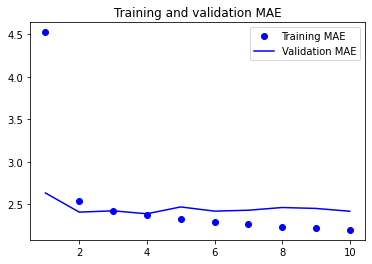

In [12]:
import matplotlib.pyplot as plt
def plot_Result(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training MAE")
    plt.plot(epochs, val_loss, "b", label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()
plot_Result(history)

### RNN stacking, GRU

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.tf",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.tf")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - ETA: 0s - loss: 24.1276 - mae: 3.6471INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf\assets


INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf\assets


819/819 [==============================] - 138s 165ms/step - loss: 24.1276 - mae: 3.6471 - val_loss: 9.4575 - val_mae: 2.3962
Epoch 2/50
819/819 [==============================] - ETA: 0s - loss: 14.1293 - mae: 2.9120INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf\assets


INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf\assets


819/819 [==============================] - 145s 178ms/step - loss: 14.1293 - mae: 2.9120 - val_loss: 9.1725 - val_mae: 2.3440
Epoch 3/50
819/819 [==============================] - ETA: 0s - loss: 13.2600 - mae: 2.8220INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf\assets


INFO:tensorflow:Assets written to: jena_stacked_gru_dropout.tf\assets


819/819 [==============================] - 152s 185ms/step - loss: 13.2600 - mae: 2.8220 - val_loss: 8.6634 - val_mae: 2.2859
Epoch 4/50
819/819 [==============================] - 150s 183ms/step - loss: 12.7313 - mae: 2.7603 - val_loss: 9.3377 - val_mae: 2.3845
Epoch 5/50
819/819 [==============================] - 145s 177ms/step - loss: 12.1796 - mae: 2.7047 - val_loss: 9.2207 - val_mae: 2.3645
Epoch 6/50
819/819 [==============================] - 144s 176ms/step - loss: 11.7193 - mae: 2.6517 - val_loss: 8.6811 - val_mae: 2.2833
Epoch 7/50
819/819 [==============================] - 145s 177ms/step - loss: 11.2425 - mae: 2.6019 - val_loss: 9.0120 - val_mae: 2.3299
Epoch 8/50
819/819 [==============================] - 144s 176ms/step - loss: 10.9163 - mae: 2.5643 - val_loss: 8.9522 - val_mae: 2.3336
Epoch 9/50
819/819 [==============================] - 147s 179ms/step - loss: 10.5636 - mae: 2.5221 - val_loss: 9.1881 - val_mae: 2.3463
Epoch 10/50
819/819 [==============================]

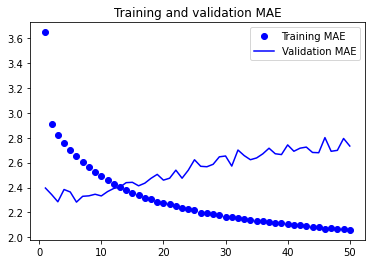

In [14]:
plot_Result(history)

### Bidirectional RNNs
The model trained on RNN in order and in reverse order, combine the results of two models with a dense connection.

Epoch 1/10
819/819 [==============================] - 36s 40ms/step - loss: 24.2204 - mae: 3.5446 - val_loss: 10.4653 - val_mae: 2.5065
Epoch 2/10
819/819 [==============================] - 34s 42ms/step - loss: 9.2640 - mae: 2.3808 - val_loss: 10.0684 - val_mae: 2.4600
Epoch 3/10
819/819 [==============================] - 33s 40ms/step - loss: 8.3113 - mae: 2.2465 - val_loss: 9.7456 - val_mae: 2.4241
Epoch 4/10
819/819 [==============================] - 33s 40ms/step - loss: 7.8253 - mae: 2.1794 - val_loss: 9.9417 - val_mae: 2.4493
Epoch 5/10
819/819 [==============================] - 33s 40ms/step - loss: 7.5280 - mae: 2.1394 - val_loss: 9.9587 - val_mae: 2.4546
Epoch 6/10
819/819 [==============================] - 33s 40ms/step - loss: 7.1875 - mae: 2.0925 - val_loss: 10.4354 - val_mae: 2.5046
Epoch 7/10
819/819 [==============================] - 33s 40ms/step - loss: 6.9387 - mae: 2.0574 - val_loss: 10.2869 - val_mae: 2.4942
Epoch 8/10
819/819 [==============================] - 33s

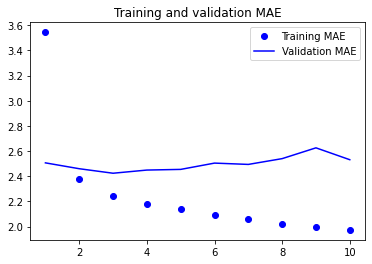

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)
plot_Result(history)